# Preliminaries and Imports
In the following cell, the necessary packages and libraries are imported.

In [50]:
# access to different databases
import pandas_datareader as web
import quandl as quandl
import wrds as wrds

# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
from tqdm import tqdm

# statistics and regression
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy.stats.mstats import winsorize
import quantstats as qs

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.axis import Axis
import matplotlib.dates as mdates 
%matplotlib inline

# warning
import warnings
warnings.filterwarnings("ignore")

# unzipping zip-files
from zipfile import ZipFile

# Data Imports and Preperations

In [55]:
# define an useful path
path = Path('/Users/sebastiansydow/13_Quant_Trading/Group_Project')
# stocks
input_stocks = path / 'permno_selection.csv'
# link betweeen CRSP (permno) and Option Metrics (SECID)
link_permno_secid = path / 'daily_permno_secid_cusip_link.csv.zip'
# glb
glb = path / 'glb_daily.csv'
# model-free implied skewness (MFIS)
mfis = path / 'mfis.csv'

# import stocks from S&P 500 into a pandas dataframe
df_input_stocks = pd.read_csv(input_stocks)
# glb
df_glb = pd.read_csv(glb)
## rename column
df_glb = df_glb.rename(columns={"id": "permno"})
## transfrom data type
df_glb['date'] = pd.to_datetime(df_glb['date'])
# mfis
df_mfis = pd.read_csv(mfis)
## rename column
df_mfis = df_mfis.rename(columns={"id": "permno"})
## transfrom data type
df_mfis['date'] = pd.to_datetime(df_glb['date'])

# instantiate zip-file
zip_file = ZipFile(link_permno_secid)
# load linking table
df_link_permno_secid = pd.read_csv(zip_file.open('daily_permno_secid_cusip_link.csv'))

## Daily Stock Returns, Market Capitalization and Value Weights

In [3]:
def retrieve_stock_data(df_input, date_start, date_end, wrds_username):
    # Download stock data
    ## establish WRDS connection
    db = wrds.Connection(wrds_username=wrds_username)
    
    # create query to load the returns, prices and shares outstanding for S&P 500 companies from 1999/01
    sql_wrds = """
            select distinct date, 
                            permno,
                            cusip, 
                            ret, 
                            abs(prc) as prc, 
                            shrout,
                            abs(prc)*shrout/1000 as mktval
            from crsp.dsf 
            where permno in %(permno)s and date>=%(start)s and date<=%(end)s
            """

    # define the parameters, i.e. only those companies (permno), which were part of the S&P 500
    # in the timeframe 2000/01 until 2020/12
    params = {}
    params['start'] = date_start
    params['end'] = date_end
    params['permno'] = tuple(df_input.permno.unique().astype(str))

    # retrieve the data from wrds
    df_stock_data = db.raw_sql(sql_wrds, params = params)

    # change type of entries in the columns start and ending
    df_stock_data['date']  = pd.to_datetime(df_stock_data['date'])
    
    # shift market_val by 1 day
    df_stock_data.loc[:,'mktval_shifted'] = df_stock_data.groupby(['permno'])['mktval'].shift(1)
    
    # dropna
    df_stock_data.dropna(inplace=True)
    
    # calculate weight of each stock on each day
    ## dataframe with total market value on each day
    df_ttl_mkcap = df_stock_data[['date', 'mktval_shifted']].groupby('date').sum().rename(columns={"mktval_shifted": "ttl_mktval"})
    ## merge with df_stock_data
    df_stock_data = pd.merge(df_stock_data, df_ttl_mkcap, how='left', on=['date'])
    ## calculate weightage
    df_stock_data['weightage_pct'] =  df_stock_data['mktval_shifted'] / df_stock_data["ttl_mktval"]
    ## drop columns
    df_stock_data.drop(columns = {'prc', 'shrout', 'mktval', 'mktval_shifted', 'ttl_mktval'}, inplace = True)
    
    return df_stock_data.sort_values(by=['date']).reset_index(drop=True)

## Fama-French-Factors

In [4]:
def download_ffm(date_start, date_end):
    # start of time period 
    startdt = datetime.datetime(int(date_start[:4]),
                                int(date_start[5:7]),
                                int(date_start[8:]))
    
    # end of time period                            
    enddt = datetime.datetime(int(date_end[:4]),
                              int(date_end[5:7]),
                              int(date_end[8:]))

    # define which dataset are to be downloaded
    d1 = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start=startdt, end=enddt)
    d2 = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start=startdt, end=enddt)

    # key is 0 -> get returns data
    # divide by 100 to get the returns
    df_ff_3factor = d1[0]/100

    # add momentum factor with an outer-join
    # outer-join: keep all data -> union
    df_ff_4factor = df_ff_3factor.join(d2[0]/100, how = 'outer')

    # reset index for merge later
    df_ff_4factor = df_ff_4factor.reset_index()

    # change columns to be small letters and get rid of white-spaces
    df_ff_4factor.columns = [z.lower().strip() for z in df_ff_4factor.columns]

    # rename column
    df_ff_4factor.rename(columns = {'mkt-rf':'mktrf'}, inplace = True)

    # change order of dataframe
    df_ff_4factor = df_ff_4factor.loc[:,['date', 'mktrf', 'smb', 'hml', 'mom', 'rf']]
                              
    return df_ff_4factor

## Calculate Excess Return

In [5]:
def calc_excess_return(df, minuend, subtrahend):
    # calculate excess return
    df['excess_return'] = df[minuend]-df[subtrahend]
    return df

## Perfrom Data Preparation 

In [6]:
def data_prep(df_input, date_start, date_end, df_link, wrds_username, minuend, subtrahend):

    ## retrieve data
    df_stock_data = retrieve_stock_data(df_input=df_input_stocks, 
                                        date_start=date_start, 
                                        date_end=date_end, 
                                        wrds_username=wrds_username)
    
    # change type of entries in the columns date
    df_link['date']  = pd.to_datetime(df_link['date'])
    
    ## merge with cusip
    df_stock_data = pd.merge(df_stock_data, df_link.loc[:,['permno', 'date', 'secid']], how = "left", on = ['permno','date'])
    
    
    # Download Fama-French Factors
    df_ffm = download_ffm(date_start=date_start, date_end=date_end)
    
    ## merge stock data with ffm
    # merge with ff-4-factors
    df_stocks_ffm = pd.merge(df_stock_data, df_ffm, how='inner', on=['date'])
    
    # calculate excess return
    df_stocks_ffm = calc_excess_return(df=df_stocks_ffm, minuend=minuend, subtrahend=subtrahend)
    
    return df_stocks_ffm

In [7]:
df_prepared = data_prep(df_input=df_input_stocks,
                        date_start='1999-01-01',
                        date_end='2020-12-31',
                        df_link=df_link_permno_secid,
                        wrds_username='sebastiansydow',
                        minuend='ret',
                        subtrahend='rf')

Loading library list...
Done


# Estimation of $\beta$-Factors

In [8]:
def estimate_betas(df, window_size, period='daily'):
    # identify all companies (permnos) in the dataframe
    permnos = df.permno.unique()
    # loop over all permnos and perform ols regression
    for permno in tqdm(range(len(permnos))):
        # define dataframe only with current permno
        df_current_permno = df[df['permno'] == permnos[permno]]
        # only perform OLS for stocks with more than 252 observations
        if len(df_current_permno) > window_size:
            # dependent variable
            Y = df_current_permno['excess_return']
            # independent variable
            X = df_current_permno[['mktrf', 'smb', 'hml', 'mom']]
            # define constant
            X_constant = sm.add_constant(X)
            # define model
            rol_ols_model = RollingOLS(endog=Y, exog=X_constant, window=window_size)
            # fitting
            # print('Fitting rolling OLS model for permno #', permno, ' from', len(permnos))
            results = rol_ols_model.fit()
            # parameters
            if permno == 0:
                df_params = results.params
            else:
                df_params = pd.concat([df_params, results.params])

    # rename columns
    df_params.rename(columns = {'mktrf':'beta1', 'smb':'beta2', 'hml':'beta3', 'mom': 'beta4'}, inplace = True)
    # merge with df_all by index
    print('Merging the dataframes...')
    df_betas = pd.merge(df, df_params, how='left', left_index=True, right_index=True, suffixes=[None, None])
    # print df_ols
    
    if period == 'daily':
        df_betas.dropna(inplace=True)
        df_betas = df_betas.reset_index(drop=True)
        return df_betas
    
    if period == 'monthly':
        # create a temporary copy of df_ols
        df_temp = df_betas[['permno', 'date', 'const', 'beta1', 'beta2', 'beta3', 'beta4']].copy()

        # add necessary columns for group by
        df_temp['year'] = df_temp['date'].dt.year
        df_temp['month'] = df_temp['date'].dt.month
        # group dataframe and select last row 
        df_temp = df_temp.groupby(['permno','year', 'month']).tail(n=1)
        
        # rename columns to indicate that those are the betas of the end of each month
        df_temp.rename(columns = {'const':'const_eom', 'beta1':'beta1_eom', 'beta2':'beta2_eom', 'beta3':'beta3_eom', 'beta4':'beta4_eom'}, inplace = True)
        # merge with df_ols
        df_betas_monthly = pd.merge(df_betas, df_temp, how='left', on=['date', 'permno'])
        # forward fill estimaed beta factors to assume that they stay constant for the next month until the last day
        gb = df_betas_monthly.groupby('permno')
        for var in ["const_eom", "beta1_eom", "beta2_eom", "beta3_eom", "beta4_eom"]:
            df_betas_monthly[var] = gb[var].ffill()
        
        # drop daily betas
        df_betas_monthly.drop(columns = {'const', 'beta1', 'beta2', 'beta3', 'beta4', 'year', 'month'}, inplace = True)

        # drop nas
        df_betas_monthly.dropna(inplace=True)

        # reset index of df
        df_betas_monthly = df_betas_monthly.reset_index(drop=True)
        
        return df_betas_monthly

In [9]:
df_betas = estimate_betas(df=df_prepared, window_size=252, period='monthly')

100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


Merging the dataframes...


# Plotting of Return

In [10]:
# define a function to calculate the valued weighted average
def weighted_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [51]:
def plot_benchmark_performance(df, column_ret, column_weight):
    # calculate benchmark performance on each day
    df_plot = (df.groupby(['date']).apply(weighted_avg, column_ret, column_weight)+1)
    df_plot.iloc[0] = df_plot.iloc[0] * 100
    
    # size of the plot
    fig, ax = plt.subplots(1, 1, figsize=(8,8))

    # define the spacing on the x-axis
    ## major ticks every 4 years
    major_ticks_years = mdates.YearLocator(4)  
    Axis.set_major_locator(ax.xaxis, major_ticks_years) 
    ## Minor ticks every year 
    minor_ticks_year = mdates.YearLocator(1)
    Axis.set_minor_locator(ax.xaxis, minor_ticks_year)

    # title
    plt.title(r"Value-Weighted Excess-Return of the Benchmark-Portfolio")

    # format the date type to year on the x-axis
    ax.format_xdata = mdates.DateFormatter('% m')

    # 9/11
    ax.annotate('9/11', xy=('2001-09-11 00:00:00', 120), xytext=(15, 15), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.axvline(x=pd.to_datetime('2001-09-11'), color='r', linestyle='--', lw=1)

    # bankruptcy Lehman 
    ax.annotate('Bankruptcy Lehman Brothers', xy=('2008-09-15 00:00:00', 90), xytext=(15, 15), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.axvline(x=pd.to_datetime('2008-09-15'), color='r', linestyle='--', lw=1)

    # covid
    ax.annotate('Covid-19', xy=('2020-03-16 00:00:00', 350), xytext=(-60, 5), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.axvline(x=pd.to_datetime('2020-03-16'), color='r', linestyle='--', lw=1)

    # define start and end of x-axis
    ax.set_xlim(min(df['date']), max(df['date']))

    # define labels of x- and y-axis
    ax.set(xlabel="Date",
           ylabel="Performance in % (Value-Weighted Mean of Benchmark Portfolio)")

    ax.plot(df_plot.cumprod(), label="Excess Return Benchmark")
    ax.legend(loc="upper left")
    # df_plot.cumprod().plot(figsize=(10,10))
    
    # quant_stats
    # qs.reports.html(df_plot.cumprod())

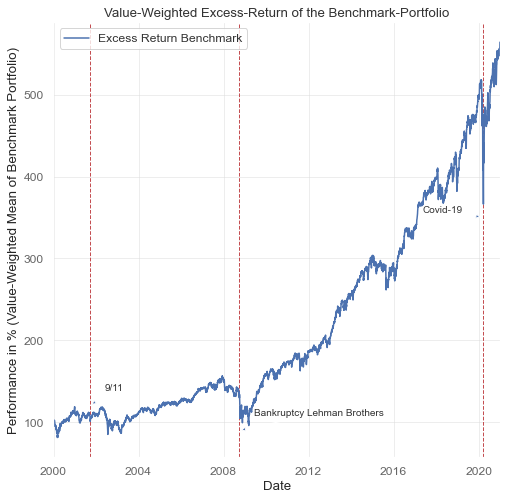

In [52]:
plot_benchmark_performance(df=df_betas, column_ret='excess_return', column_weight='weightage_pct')

# Option-Implied Data and Option Metrics
## GLB and MFIS

In [58]:
# merge data with glb
df_stocks_betas_options = pd.merge(df_betas, df_glb, how="left", on=['permno', 'date'])
# merge data with mfis
df_stocks_betas_options = pd.merge(df_stocks_betas_options, df_mfis, how='left', on=['permno', 'date'])

### Average Volatility [AIV] of all OTM Call and Put Options and SKEW

In [68]:
def retrieve_option_metrics(df, start_year, end_year, days, delta_otm_put, delta_atm_call, wrds_username):
    
    ## establish WRDS connection
    db = wrds.Connection(wrds_username=wrds_username)
    
    # define the parameters
    params = {}
    params['secids'] = tuple(df.secid.unique())
    params['days'] = days
    params['delta_otm_put'] = delta_otm_put
    params['delta_atm_call'] = delta_atm_call

    # define the sql query
    sql = '''
    select a.date, a.secid, a.iv-b.iv as skew, c.iv from 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_atm_call)s) as a, 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_otm_put)s) as b, 

    (select date, secid, AVG(impl_volatility) as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and abs(delta)<=50
    group by date, secid) as c

    where a.date= b.date and a.secid = b.secid 
    and a.date = c.date and a.secid = c.secid
    '''
    # retrieve data for 1999
    params['year'] = start_year
    df_optiondata = db.raw_sql(sql, params = params)

    # append data for each year from 2000 to 2020
    for y in tqdm(range(start_year+1,end_year)):
        # print('Processing year ', y)
        # set parameter for the year
        params['year'] = y
        df_optiondata = pd.concat([df_optiondata, db.raw_sql(sql, params = params)])
        
    return df_optiondata

In [77]:
df_option_metrics = retrieve_option_metrics(df=df_stocks_betas_options,
                                            start_year=1999,
                                            end_year=2021,
                                            days=30,
                                            delta_otm_put=-10,
                                            delta_atm_call=50,
                                            wrds_username="sebastiansydow")

# change type of entries in the column data
df_option_metrics.loc[:,'date'] = pd.to_datetime(df_option_metrics.loc[:,'date'])

# merge optiondata and stockdata
df_stocks_betas_options = pd.merge(df_stocks_betas_options, df_option_metrics, how='inner', on=['secid', 'date'])

Loading library list...
Done


100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


# Data Cleaning

In [85]:
def count_nan(df):
    # Count NaN
    df_count_nan = df.isna().sum().reset_index(name="Count NaN")
    # Rename column
    df_count_nan = df_count_nan.rename(columns={"index": "Column"})
    # Plot
    df_count_nan.plot.bar(x='Column', 
                          y='Count NaN', 
                          rot=45, 
                          figsize=(16,6), 
                          title="Count NaN per Column")

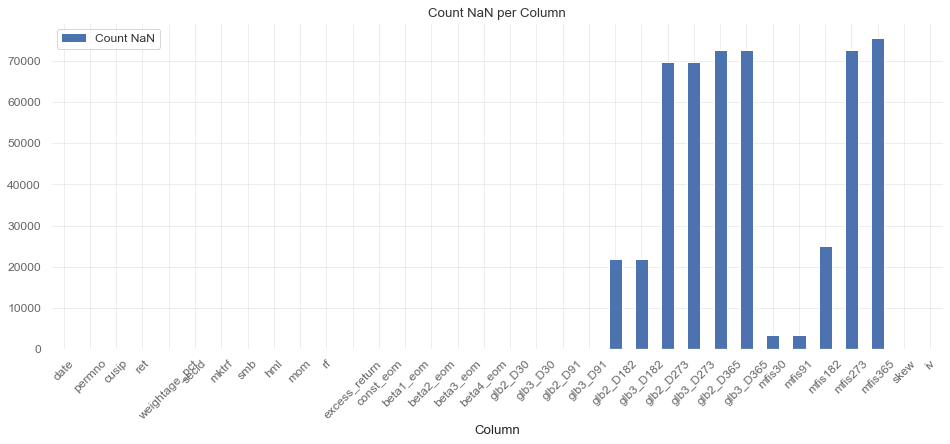

In [86]:
count_nan(df=df_stocks_betas_options)

In [88]:
def corrmatrix_heatmap(df, columns):
    
    X = df[columns]

    # Compute the correlation matrix
    corrMatrix = X.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    sns.heatmap(corrMatrix, annot=True)
    # plt.savefig('corrMatrix_heatmap.jpeg', dpi=200, format='jpeg')

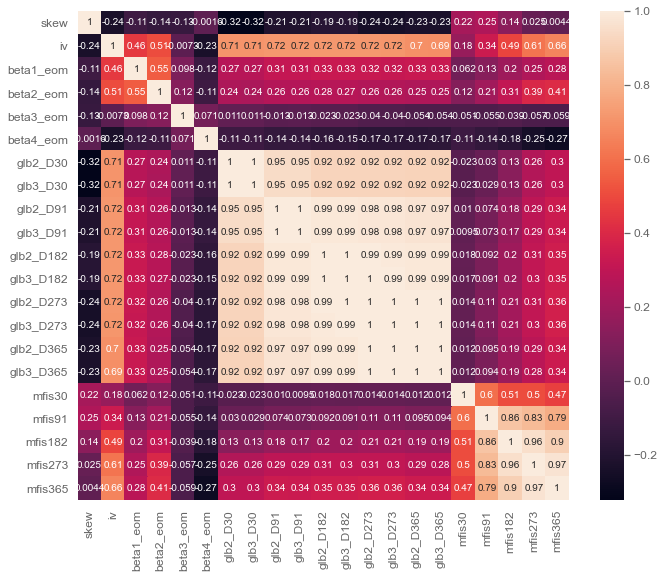

In [90]:
# define columns to calculate pearson correlation coefficient for
columns = ['skew', 
           'iv', 
           'beta1_eom', 
           'beta2_eom', 
           'beta3_eom', 
           'beta4_eom', 
           'glb2_D30', 
           'glb3_D30', 
           'glb2_D91',
           'glb3_D91',
           'glb2_D182', 
           'glb3_D182', 
           'glb2_D273',
           'glb3_D273',
           'glb2_D365',
           'glb3_D365',
           'mfis30', 
           'mfis91', 
           'mfis182', 
           'mfis273', 
           'mfis365']

# execute function
corrmatrix_heatmap(df=df_stocks_betas_options, columns=columns)